# GTSRB Classification with VGG-19

In [4]:
import os
import cv2
import csv
import numpy as np
from time import time
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG19
import matplotlib.pyplot as plt
%matplotlib inline

## The data

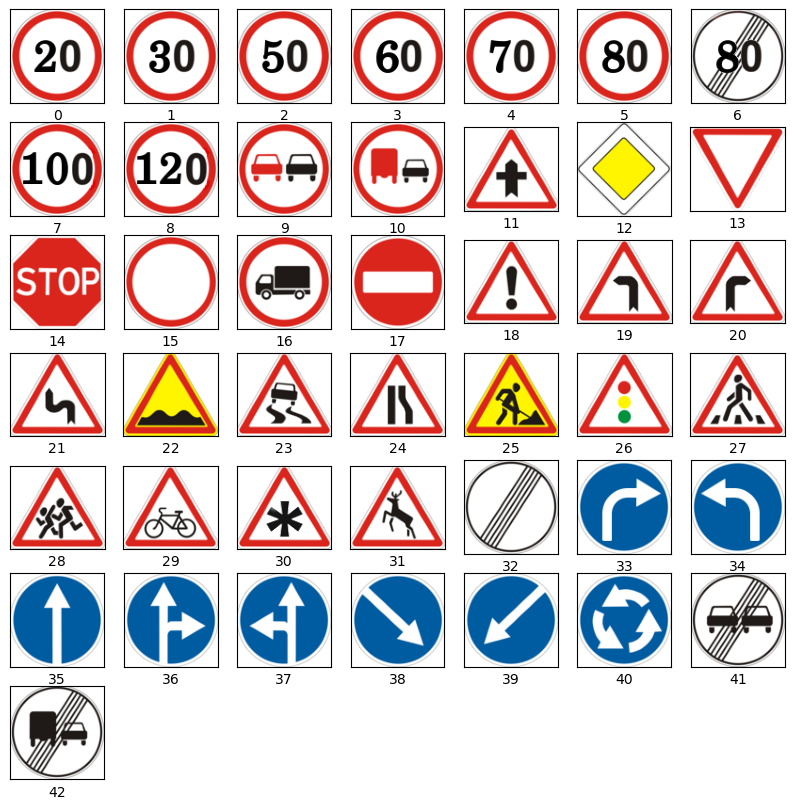

In [5]:
dir = '../../Dataset/GTSRB/'
    
plt.figure(figsize=(10, 10))
for i in range (0,43):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    path = dir + "/Meta/{0}.png".format(i)
    img = plt.imread(path)
    plt.imshow(img)
    plt.xlabel(i)

## Loading

In [6]:
def preprocess(image, out_side):
    height, width = image.shape[:2]
    scale = out_side / max(height, width)
    dx = (out_side - scale * width) / 2
    dy = (out_side - scale * height) / 2
    trans = np.array([[scale, 0, dx], [0, scale, dy]], dtype=np.float32)
    image = cv2.warpAffine(image, trans, (out_side, out_side), flags=cv2.INTER_AREA)
    image = cv2.resize(image, (out_side, out_side))
    return image

def mixing(images, labels):
    images = np.array(images)
    labels = np.array(labels)
    s = np.arange(images.shape[0])
    np.random.seed(43)
    np.random.shuffle(s)
    images=images[s]
    labels=labels[s]
    return images, labels

def load_train(path, out_side):
    images = []
    labels = []
    for folder in os.listdir(os.path.join(path, 'Train')):
        cur_path = os.path.join(path, 'Train', folder)
        for file_name in os.listdir(cur_path):
            image = cv2.imread(os.path.join(cur_path, file_name))
            images.append(preprocess(image, out_side))
            labels.append(int(folder))

    return mixing(images, labels)

def load_test(path, out_side):
    images = []
    labels = []
    with open(os.path.join(path, 'Test.csv'), 'r') as f:
        reader = csv.reader(f)
        for rows in reader:
            name = rows[7]
            if (name == 'Path'):
                continue
            image = cv2.imread(os.path.join(path, rows[7]))
            images.append(preprocess(image, out_side))
            labels.append(int(rows[6]))

    return mixing(images, labels)

In [7]:
start = time()

train_images, train_labels = load_train(dir + "/", 50)
test_images, test_labels = load_test(dir + "/", 50)
shape = train_images[0].shape
print(shape)

train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.

train_labels = utils.to_categorical(train_labels, 43)
test_labels = utils.to_categorical(test_labels, 43)

print('Loading: ', time() - start)

(50, 50, 3)
Loading:  10.82888388633728


## Network

In [8]:
classes = 43
batch = 256
epochs = 3
learning_rate = 0.0001

def results(model):
    adam = Adam(learning_rate=learning_rate)  

    # Compile the model
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    start = time()
    history = model.fit(train_images, train_labels, batch_size=batch, epochs=epochs, 
                        validation_split=0.2, shuffle=True, verbose=1)
    train_time = time() - start

    # Display the model summary
    model.summary()

    # Plot training and validation accuracy and loss
    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()

    plt.subplot(3, 2, 2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    # Evaluate the model on test data
    start = time()
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    test_time = time() - start

    # Print training and testing results
    print('\nTrain time: ', train_time)
    print('Test accuracy:', test_acc)
    print('Test loss:', test_loss)
    print('Test time: ', test_time)

## Configuration

Epoch 1/3
123/123 ━━━━━━━━━━━━━━━━━━━━ 422s 3s/step - accuracy: 0.5521 - loss: 1.8824 - val_accuracy: 0.9870 - val_loss: 1.0465
Epoch 2/3
123/123 ━━━━━━━━━━━━━━━━━━━━ 420s 3s/step - accuracy: 0.9912 - loss: 0.0763 - val_accuracy: 0.9895 - val_loss: 0.2576
Epoch 3/3
123/123 ━━━━━━━━━━━━━━━━━━━━ 420s 3s/step - accuracy: 0.9951 - loss: 0.0335 - val_accuracy: 0.9959 - val_loss: 0.0505


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 1, 1, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 1, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        44,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,785,411 (235.69 MB)

 Trainable params: 20,594,795 (78.56 MB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 41,189,592 (157.13 MB)

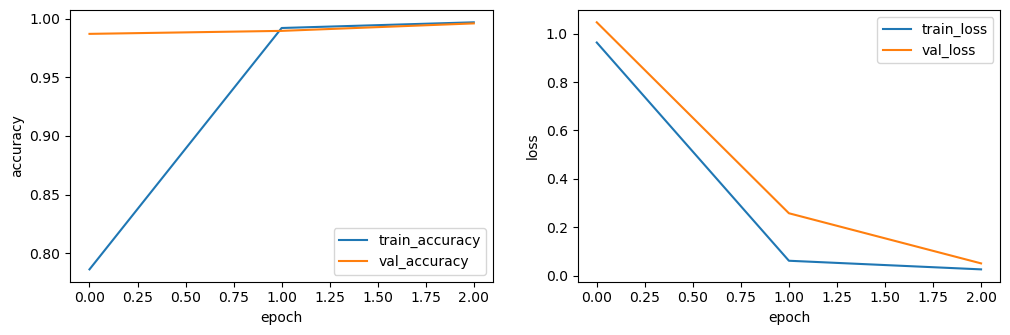

395/395 ━━━━━━━━━━━━━━━━━━━━ 41s 103ms/step - accuracy: 0.9702 - loss: 0.1512

Train time:  1262.574337720871
Test accuracy: 0.9682502150535583
Test loss: 0.15095797181129456
Test time:  40.92746114730835


In [9]:
model = Sequential()
model.add(VGG19(weights='imagenet', include_top=False, input_shape=(50,50,3)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(1024, activation='sigmoid'))
model.add(Dense(43, activation='softmax'))

results(model)

In [10]:
model.save('../VGG-19/saved_model/vgg19_trained_model.h5')